# Template Molecule-based Temperature Map

First, we'll import the noise map, from which we'll begin error propagation.

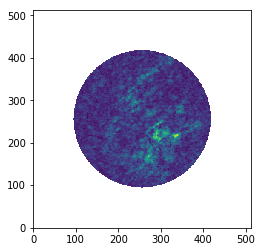

In [10]:
%matplotlib inline
from pylab import imshow
from astropy.io import fits
hdu = fits.open('methyl_cyanide/template_noise.fits')
noise_map = hdu[0].data
imshow(noise_map, origin='lower') 

Now, we'll retrieve some values we need for each rung from the methyl cyanide cube table.

In [11]:
from spectral_cube import SpectralCube
from astropy import units as u
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'

# Get methyl cyanide (target molecule) cube
freq_spw = '146_spw51'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
ch3cncube = SpectralCube.read(fn, format='casa_image')

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


In [12]:
from astroquery.splatalogue import Splatalogue
ch3cntbl = ch3cncube.find_lines(chemical_name='CH3CN', line_lists=['JPL'], 
                                show_upper_degeneracy=True, show_qn_code=True)
ch3cntbl = ch3cntbl[ch3cntbl['Quantum Number Code'] == 202]
ch3cntbl = ch3cntbl[::-1]
ch3cn_freqs = ch3cntbl['Freq-GHz(rest frame,redshifted)']
ch3cntbl.show_in_notebook()

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Quantum Number Code,Linelist
0,CH3CNv=0,Methyl Cyanide,147.1745883,2e-07,--,--,8(0)-7(0),-2.6575,169.60673,11.02642,-3.7326,--,17.1828,24.72238,22.09202,31.78569,34.0,202,JPL
1,CH3CNv=0,Methyl Cyanide,147.1717519,2e-07,--,--,8(1)-7(1),-2.6748,166.91824,10.85164,-3.73957,--,22.1491,31.86782,27.05822,38.931,34.0,202,JPL
2,CH3CNv=0,Methyl Cyanide,147.1632441,2e-07,--,--,8(2)-7(2),-2.727,158.99516,10.33654,-3.76076,--,37.047,53.30272,41.95584,60.36548,34.0,202,JPL
3,CH3CNv=0,Methyl Cyanide,147.1490683,1e-07,--,--,8(3)-7(3),-2.5156,291.45821,18.94819,-3.79873,--,61.8731,89.02217,66.78146,96.08426,68.0,202,JPL
4,CH3CNv=0,Methyl Cyanide,147.1292302,1e-07,--,--,8(4)-7(4),-2.9482,127.19471,8.26914,-3.85798,--,96.6217,139.01798,101.5294,146.07911,34.0,202,JPL
5,CH3CNv=0,Methyl Cyanide,147.103738,1e-07,--,--,8(5)-7(5),-3.1316,103.33459,6.71796,-3.94843,--,141.2849,203.27878,146.19175,210.33869,34.0,202,JPL
6,CH3CNv=0,Methyl Cyanide,147.0726021,1e-07,--,--,8(6)-7(6),-3.0883,148.38336,9.64665,-4.09259,--,195.8526,281.79004,200.75841,288.84846,68.0,202,JPL
7,CH3CNv=0,Methyl Cyanide,147.0358351,1e-07,--,--,8(7)-7(7),-3.7949,39.74307,2.58376,-4.36401,--,260.3123,374.53377,265.21689,381.59042,34.0,202,JPL


In [13]:
# We already have ch3cn_freqs
ch3cn_A = 10**ch3cntbl['Log<sub>10</sub> (A<sub>ij</sub>)']
ch3cn_g = ch3cntbl['Upper State Degeneracy']
ch3cn_E_U = ch3cntbl['E_U (K)'][:,None,None] # This is already divided by the Boltzmann constant, I think?

Now, we'll go through each rung of the ladder and get the upper state column density from the moment 0 map for each rung. We'll store those upper state column density maps for fitting in the next step, and we'll plot the moment 0 maps next to the upper state column density maps for each *k*-component.

We will also propagate errors on the noise map for each of the *k*-components.

In [14]:
import numpy as np
from lte_modeling_tools import nupper_of_kkms
from astropy import constants
import matplotlib.pyplot as plt

log_N_upper_gs = []
log_N_upper_g_errs = []

i = 0
for i in range(0, 8):

    # Import masked cube and get channel width
    masked_cube = SpectralCube.read(f'methyl_cyanide/ch3cn_{i}_masked.fits', format='fits')
    channel_width = np.diff(masked_cube.spectral_axis)[0]

    # Calculate moment 0 and moment 1 maps of cube
    mom0 = masked_cube.moment0()
    mom1 = masked_cube.moment1()
    # Propagate error on integrated intensity
    noise_map_int = noise_map*u.K*(channel_width)

    # Calculate what the shifted line frequency for the rung should be (per pixel) with mom1
    shifted_line_freqs = (ch3cn_freqs[i]-((mom1/(constants.c.to(u.km/u.s)))*ch3cn_freqs[i]))*u.GHz # Maybe okay?

    # Calculate upper state column density from integrated line intensity (moment 0 map)
    N_upper = nupper_of_kkms(mom0, shifted_line_freqs, ch3cn_A[i])
#     print(np.nanmean(N_upper))
    log_N_upper_g = np.log10(N_upper.data/ch3cn_g[i]) # Shouldn't have to do .data?
#     print(np.nanmean(log_N_upper_g))
    # Propagate error on upper state column density
    N_upper_err = nupper_of_kkms(noise_map_int, shifted_line_freqs, ch3cn_A[i])
    log_N_upper_g_err = N_upper_err/(N_upper*np.log(10.)) # There's no g here b/c it's a constant?

    # Append upper state column density maps and error maps into lists
    log_N_upper_gs.append(log_N_upper_g)
    log_N_upper_g_errs.append(log_N_upper_g_err)
    
    # Plot moment 0 and upper state column density maps for each rung next to each other
#     fig = plt.figure(figsize = (20, 10))
#     im = plt.subplot(1,2,1).imshow(mom0.value, origin='lower', cmap='magma')
# #     plt.colorbar(mappable = im)
#     plt.title(f"Methyl Cyanide $j = 8$, $k = {i}$ Moment 0 Map")
#     im = plt.subplot(1,2,2).imshow(log_N_upper_g, origin='lower', cmap='magma')
# #     plt.colorbar(mappable = im)
#     plt.title(f"Methyl Cyanide $j = 8$, $k = {i}$ Upper State Column Density Map")
#     plt.show()

    print(np.nanmin(log_N_upper_g)) # These values seem a little low
    print(np.nanmax(log_N_upper_g))
    
    i += 1

log_N_upper_gs = np.array(log_N_upper_gs)
log_N_upper_g_errs = np.array(log_N_upper_g_errs)

/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


9.302512879757748
10.734321667196859


/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


9.309989539187043
10.65498662154337


/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


9.330653882172284
10.279151233365704


/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


9.067529272068185
10.286262457129


/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


9.427649747707633
10.270446876646966


/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


9.518018547171938
10.07086746747252


/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


9.360976587277735
9.957125836511395
9.93457407902541
10.433040700797344


/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))


Lastly, we'll perform parallelized (all pixels at once, along the *k*-component axis) fitting of the upper state column density versus the upper state energy level. We'll start by initializing the values that we're going to fit.

In [15]:
# Convert to natural log for fitting
ln_N_upper_gs = np.log(10**(log_N_upper_gs))
ln_N_upper_g_errs = np.log(10**(log_N_upper_g_errs))

# Replace all NaNs with 0s
ln_N_upper_gs = np.nan_to_num(ln_N_upper_gs)
ln_N_upper_g_errs = np.nan_to_num(ln_N_upper_g_errs)

In [16]:
## Some stuff that didn't work:
# valid_map = np.isfinite(log_N_upper_gs)
# valid_map.shape
# # Build up E_U matrix by hand, to be masked (to go with second fitting attempt)
# E_U_matrix = []
# i = 0
# for i in range(0, 8):
#     new_map = np.ones((512, 512))
#     new_map *= ch3cn_E_U[i,0,0]
#     E_U_matrix.append(new_map)
#     i += 1
# E_U_matrix = np.array(E_U_matrix)
# np.array([ch3cn_E_U[:,0,0], np.ones(ch3cn_E_U.shape[0])]).T
# log_N_upper_gs
# np.moveaxis(np.tile(1/(noise_map**2)[:,:,None], 8), 2, 0).shape

Let's do the fitting!

In [17]:
# Original fitting attempt
ch3cn_E_U_1d = np.array([ch3cn_E_U[:,0,0], np.ones(ch3cn_E_U.shape[0])]).T
fitshape = ln_N_upper_gs.shape[0], np.product(ln_N_upper_gs.shape[1:])
ffr = ln_N_upper_gs.reshape(fitshape)
# ffw = ffr * 1 # Ignoring weights for now 
# zzw = ch3cn_E_U_1d * 1 # Ignoring weights for now

# Do weights stuff: 
weights = np.mean(ln_N_upper_g_errs, axis=(1,2))
# weights = weights.reshape(fitshape)
ffw = ffr * weights[:,None]
zzw = ch3cn_E_U_1d * weights[:,None]

print(f"ffw.shape={ffw.shape}, zz1d.shape={ch3cn_E_U_1d.shape}")
fitted, residuals, rank, singular = np.linalg.lstsq(zzw, ffw, rcond=None)
print(f"rank={rank}, singular={singular}")

# Extract fit values
fitted_m = fitted[0].reshape(ln_N_upper_gs.shape[1:]) # not sure what fitted[0] is vs. fitted[1]
fitted_b = fitted[1].reshape(ln_N_upper_gs.shape[1:]) # m or b? we just don't know
fitted_resid = residuals.reshape(ln_N_upper_gs.shape[1:])

temperature = -1./fitted_m
ln_N = fitted_b
log_N = np.log10(np.exp(ln_N)) # Log base 10 of (e to the [natural log of N])

temperature_alt = -1./fitted_b
ln_N_alt = fitted_m
log_N_alt = np.log10(np.exp(ln_N_alt))

ffw.shape=(8, 262144), zz1d.shape=(8, 2)
rank=2, singular=[556.80638809   1.71102181]


/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


Then, let's plot the values we get!

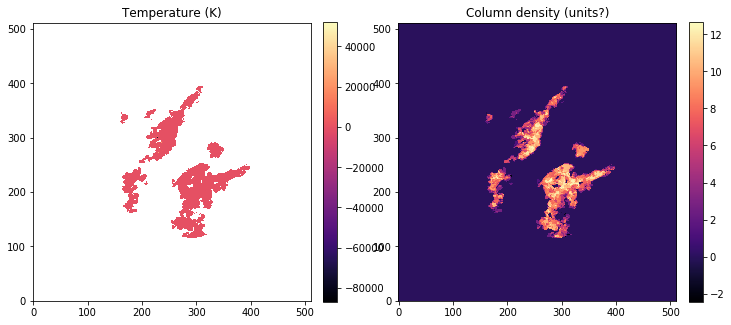

In [18]:
# Plot results
fig = plt.figure(figsize = (12, 12))
im = plt.subplot(2,2,1).imshow(temperature, origin='lower', cmap='magma'); plt.colorbar(mappable = im, fraction=0.046, pad=0.04) #, vmin=0, vmax=100 
plt.title("Temperature (K)")
im = plt.subplot(2,2,2).imshow(log_N, origin='lower', cmap='magma'); plt.colorbar(mappable = im, fraction=0.046, pad=0.04)
plt.title("Column density (units?)")
# im = plt.subplot(2,2,3).imshow(temperature_alt, origin='lower', cmap='magma'); plt.colorbar(mappable = im, fraction=0.046, pad=0.04)
# plt.title("Temperature (K, alternate)")
# im = plt.subplot(2,2,4).imshow(log_N_alt, origin='lower', cmap='magma'); plt.colorbar(mappable = im, fraction=0.046, pad=0.04)
# plt.title("Column density (units?, alternate)")
# im = plt.subplot(2,2,4).imshow(fitted_resid, origin='lower', cmap='magma'); plt.colorbar(mappable = im)
# plt.title("Fitted residuals")
plt.show()

# Making colorbars smaller
# https://stackoverflow.com/questions/16702479/matplotlib-colorbar-placement-and-size

In [19]:
# # Second fitting attempt

# # Apply valid map to both independent and dependent variables
# E_U_valid = E_U_matrix[valid_map]
# log_N_upper_gs = log_N_upper_gs[valid_map] # This is rewriting this variable, which is a bad practice

# # ch3cn_E_U_1d = np.array([ch3cn_E_U[:,0,0], np.ones(ch3cn_E_U.shape[0])]).T # what are the ones?
# fitshape = log_N_upper_gs.shape[0] #, np.product(log_N_upper_gs.shape[1:])
# ch3cn_E_U_1d = E_U_valid.reshape(fitshape)
# ffr = log_N_upper_gs.reshape(fitshape)
# print(f"ffw.shape={ffw.shape}, zz1d.shape={ch3cn_E_U_1d.shape}")
# fitted, residuals, rank, singular = np.linalg.lstsq(zzw, ffw, rcond=None)
# print(f"rank={rank}, singular={singular}")
# fitted_m = fitted[0].reshape(log_N_upper_gs.shape[1:]) # not sure what fitted[0] is vs. fitted[1]
# fitted_b = fitted[1].reshape(log_N_upper_gs.shape[1:])
# fitted_resid = residuals.reshape(log_N_upper_gs.shape[1:])

# # Plot results
# fig = plt.figure(figsize = (15, 15))
# im = plt.subplot(2,2,1).imshow(fitted_m, origin='lower', cmap='magma'); plt.colorbar(mappable = im)
# plt.title("Fitted $m$")
# im = plt.subplot(2,2,2).imshow(-1./fitted_m, origin='lower', cmap='magma'); plt.colorbar(mappable = im)
# plt.title("Fitted temperature ($-1/m$; K)")
# im = plt.subplot(2,2,3).imshow(fitted_b, origin='lower', cmap='magma'); plt.colorbar(mappable = im)
# plt.title("Fitted $b$")
# im = plt.subplot(2,2,4).imshow(-1./fitted_b, origin='lower', cmap='magma'); plt.colorbar(mappable = im)
# plt.title("Fitted temperature ($-1/b$; K)")
# # im = plt.subplot(2,2,4).imshow(fitted_resid, origin='lower', cmap='magma'); plt.colorbar(mappable = im)
# # plt.title("Fitted residuals")
# plt.show()

Because I don't trust that I did these fits correctly, let's visualize one of the rotational diagrams. I will do this for the pixel with the maximum upper state column density for the *k* = 0 line.

In [20]:
# # Plot rotational diagram for a pixel
# temp = -1./fitted_m
# max_temp_coord = np.unravel_index(np.nanargmax(temp), temp.shape)

# example_N_upper = log_N_upper_gs[:, max_temp_coord[0], max_temp_coord[1]]
# example_E_upper = ch3cn_E_U

# fig = plt.figure(figsize=(7, 4))
# plt.scatter(example_E_upper, example_N_upper)
# plt.ylabel("$\log (N_u / g)$")
# plt.xlabel("$E_u / k$ (K)")
# # plt.ylim(9.30225, 9.30275)
# plt.show()

Verification step:

In [21]:
# print(np.sum(np.isfinite(temp)))
# # test_arr = np.array([[1, np.nan, 4, np.nan],[np.nan, np.nan, 6, 7],[np.nan, 5, 8, 10]])
# # test_arr_2 = np.array([[1, np.nan, np.nan, np.nan],[np.nan, np.nan, 6, 7],[np.nan, 5, 8, 10]])
# # print(test_arr)
# # print(np.isfinite(test_arr))
# # print(np.sum(np.isfinite(test_arr)))
# # print(np.isfinite(test_arr) & np.isfinite(test_arr_2))
# all_finite = np.isfinite(log_N_upper_gs[0]) & \
#                 np.isfinite(log_N_upper_gs[1]) & \
#                 np.isfinite(log_N_upper_gs[2]) & \
#                 np.isfinite(log_N_upper_gs[3]) & \
#                 np.isfinite(log_N_upper_gs[4]) & \
#                 np.isfinite(log_N_upper_gs[5]) & \
#                 np.isfinite(log_N_upper_gs[6]) & \
#                 np.isfinite(log_N_upper_gs[7])
# print(np.sum(all_finite))
# # If both the same number, then we know np.linalg.lstsq doesn't fit a pixel if it contains a NaN

Let's try this new math with a known temperature.

In [22]:
# User inputs
T = 100*u.K # Temperature (in K)
N = 500 # Total column density (units?)

E_upper = ch3cn_E_U # Upper state energies (in K)
g_upper = ch3cn_g # Degeneracies corresponding to upper state energies

# Generate upper state column densities
N_upper = g_upper*N*np.exp(-(E_upper*u.K)/T)

# Try to get total column density and temperature out of linear fit

ln_N_upper_gs = np.log(N_upper/g_upper) # Is this valid, or should I be doing this differently?

ch3cn_E_U_1d = np.array([E_upper[:,0,0], np.ones(E_upper.shape[0])]).T
fitshape = ln_N_upper_gs.shape[0], np.product(ln_N_upper_gs.shape[1:])
ffr = ln_N_upper_gs.reshape(fitshape)
ffw = ffr * 1 # Ignoring weights for now 
zzw = ch3cn_E_U_1d * 1 # Ignoring weights for now

# # Do weights stuff: 
# weights = ln_N_upper_g_errs
# weights = weights.reshape(fitshape)
# ffw = ffr * weights[:,None]
# zzw = ch3cn_E_U_1d * weights[:,None]

print(f"ffw.shape={ffw.shape}, zz1d.shape={ch3cn_E_U_1d.shape}")
fitted, residuals, rank, singular = np.linalg.lstsq(zzw, ffw, rcond=None)
print(f"rank={rank}, singular={singular}")

# Extract fit values
fitted_m = fitted[0].reshape(ln_N_upper_gs.shape[1:]) # not sure what fitted[0] is vs. fitted[1]
fitted_b = fitted[1].reshape(ln_N_upper_gs.shape[1:]) # m or b? we just don't know
fitted_resid = residuals.reshape(ln_N_upper_gs.shape[1:])

temperature = -1./fitted_m
ln_N = fitted_b
log_N = np.log10(np.exp(ln_N)) # Log base 10 of (e to the [natural log of N])

temperature_alt = -1./fitted_b
ln_N_alt = fitted_m
log_N_alt = np.log10(np.exp(ln_N_alt))

# Comparison to see if fitting works
print(f"Input temperature: {T}")
print(f"Fitted temperature: {temperature}")
print(f"Input total column density: {N}")
print(f"Fitted total column density: {10**(log_N)}")

ffw.shape=(8, 8), zz1d.shape=(8, 2)
rank=2, singular=[556.80638809   1.71102181]
Input temperature: 100.0 K
Fitted temperature: [[100. 100. 100. 100. 100. 100. 100. 100.]]
Input total column density: 500
Fitted total column density: [[500. 500. 500. 500. 500. 500. 500. 500.]]


### Adam's code for parallelized fitting

ffw.shape=(5, 391), zz1d.shape=(5, 2)
rank=2, singular=[1.83848293 0.35627866]


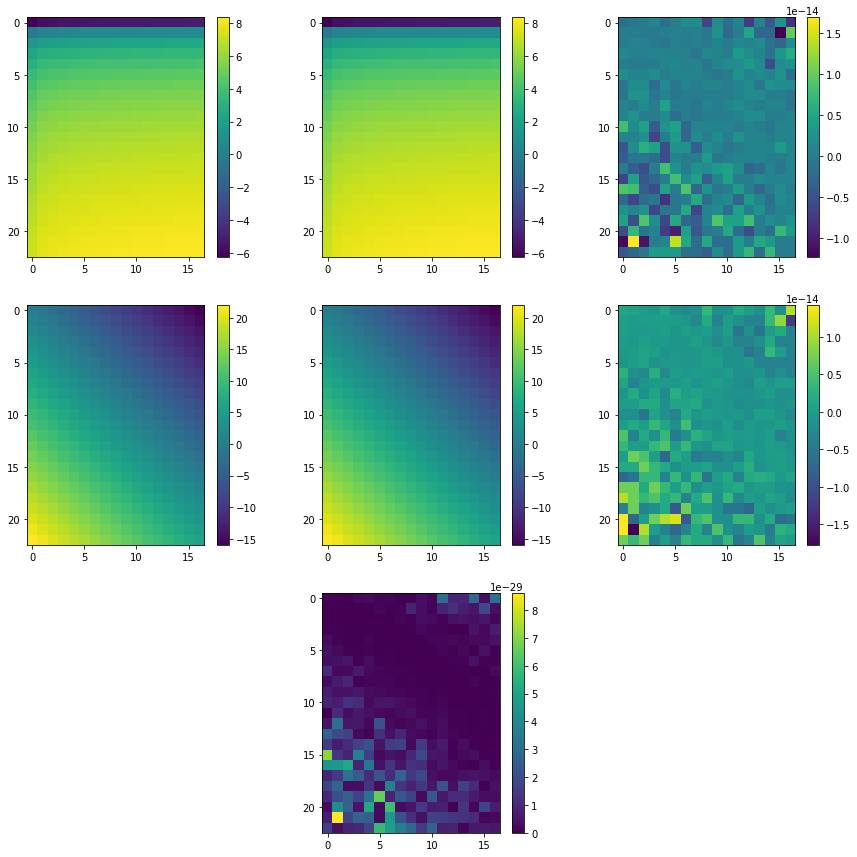

In [23]:
import pylab as pl
# make x,y axes
yy,xx = np.indices([23,17])
zz = np.linspace(0,1,5)[:,None,None]
# this works *if and only if* the weights are dependent on the Z-axis, but not the X- or Y- axis
weights = np.random.rand(zz.shape[0])
# f = mm * zz + bb
## mm, bb are arbitrarily selected
mm = 0.5 * np.log10(xx+0.1) + 2.5 * np.log(yy+0.1)
bb = yy-xx
ff = mm*zz + bb
zz1d = np.array([zz[:,0,0], np.ones(zz.shape[0])]).T
fitshape = ff.shape[0], np.product(ff.shape[1:])
ffr = ff.reshape(fitshape)
ffw = ffr * weights[:,None]
zzw = zz1d * weights[:,None]
print(f"ffw.shape={ffw.shape}, zz1d.shape={zz1d.shape}")
fitted, residuals, rank, singular = np.linalg.lstsq(zzw, ffw, rcond=None)
print(f"rank={rank}, singular={singular}")
fitted_m = fitted[0].reshape(ff.shape[1:])
fitted_b = fitted[1].reshape(ff.shape[1:])
fitted_resid = residuals.reshape(ff.shape[1:])
# verify again
_=pl.figure(figsize=(15,15))
im=pl.subplot(3,3,1).imshow(mm); pl.colorbar(mappable=im)
im=pl.subplot(3,3,2).imshow(fitted_m); pl.colorbar(mappable=im)
im=pl.subplot(3,3,3).imshow(fitted_m-mm); pl.colorbar(mappable=im)
im=pl.subplot(3,3,4).imshow(bb); pl.colorbar(mappable=im)
im=pl.subplot(3,3,5).imshow(fitted_b); pl.colorbar(mappable=im)
im=pl.subplot(3,3,6).imshow(fitted_b-bb); pl.colorbar(mappable=im)
im=pl.subplot(3,3,8).imshow(fitted_resid); pl.colorbar(mappable=im)

In [24]:
weights[:,None].shape

(5, 1)